# NLP Project

All the package imports.

In [1]:
from datasets import load_dataset
import pandas as pd
import re
import spacy
from spacy.lang.fi import Finnish
from spacy.lang.en import English
from spacy.lang.ja import Japanese
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from enum import Enum

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [223]:
%%capture
!python -m spacy download en_core_web_sm
!python -m spacy download fi_core_news_sm
!python -m spacy download ja_core_news_sm

### Data folder setup

In [3]:
DATA_RELATIVE_PATH = "data"

## Q1.1

Here we define some globals which will be used in Q1.1.

First, lets define the path where the preprocessed data will be stored for later use.
We could get issues if storing the data as CSV after tokenization, since the list of tokens:
"['a'], ['b']", will automatically be converted to a string (since the list contains ',').
So let's store it in pickle format.

In [4]:
path_train_set = DATA_RELATIVE_PATH + "/train_set.pkl"
path_validation_set = DATA_RELATIVE_PATH + "/validation_set.pkl"

In [5]:
def load_data():
    train_set = pd.read_pickle(path_train_set)
    validation_set = pd.read_pickle(path_validation_set)
    return train_set, validation_set

The Annotation column can have one of this value on error (or the range on success).

In [6]:
class Annotation_error(Enum):
    UNANSWERED = -1
    BAD_TOKENIZATION_OR_DATA = -2
    IGNORED = -3

## Q1.1a

Let's download the dataset from the web.

In [6]:
%%capture
dataset_raw = load_dataset("copenlu/answerable_tydiqa")

In [7]:
train_set_raw = dataset_raw["train"].to_pandas()
validation_set_raw = dataset_raw["validation"].to_pandas()

In [8]:
train_set_raw.head()

,question_text,document_title,language,annotations,document_plaintext,document_url
0,Milloin Charles Fort syntyi?,Charles Fort,finnish,"{'answer_start': [18], 'answer_text': ['6. elo...",Charles Hoy Fort (6. elokuuta (joidenkin lähte...,https://fi.wikipedia.org/wiki/Charles%20Fort
1,“ダン” ダニエル・ジャドソン・キャラハンの出身はどこ,ダニエル・J・キャラハン,japanese,"{'answer_start': [35], 'answer_text': ['カリフォルニ...",“ダン”こと、ダニエル・ジャドソン・キャラハンは1890年7月26日、カリフォルニア州サンフ...,https://ja.wikipedia.org/wiki/%E3%83%80%E3%83%...
2,వేప చెట్టు యొక్క శాస్త్రీయ నామం ఏమిటి?,వేప,telugu,"{'answer_start': [12], 'answer_text': ['Azadir...","వేప (లాటిన్ Azadirachta indica, syn. Melia aza...",https://te.wikipedia.org/wiki/%E0%B0%B5%E0%B1%...
3,চেঙ্গিস খান কোন বংশের রাজা ছিলেন ?,চেঙ্গিজ খান,bengali,"{'answer_start': [414], 'answer_text': ['বোরজি...",চেঙ্গিজ খান (মঙ্গোলীয়: Чингис Хаан আ-ধ্ব-ব: ...,https://bn.wikipedia.org/wiki/%E0%A6%9A%E0%A7%...
4,రెయ్యలగడ్ద గ్రామ విస్తీర్ణత ఎంత?,రెయ్యలగడ్ద,telugu,"{'answer_start': [259], 'answer_text': ['27 హె...","రెయ్యలగడ్ద, విశాఖపట్నం జిల్లా, గంగరాజు మాడుగుల...",https://te.wikipedia.org/wiki/%E0%B0%B0%E0%B1%...


In [9]:
def print_preprocessing_summary(df):
    num_unanswered = df[df['document_answer_region'] == Annotation_error.UNANSWERED].shape[0]
    num_answered_but_failed = df[df['document_answer_region'] == Annotation_error.BAD_TOKENIZATION_OR_DATA].shape[0]
    num_answered = df.shape[0] - num_answered_but_failed - num_unanswered

    print("[Parsing Info] {} answered questions. {} unanswered questions. Failed to parse {} (answered) questions.".format(num_answered, num_unanswered, num_answered_but_failed))

Let's do some preprocessing!

In [10]:
def our_tokenizer(nlp):
    infixes = nlp.Defaults.infixes + [r"[\.\,]?\[\S*"]
    infix_re = spacy.util.compile_infix_regex(infixes)
    prefix_re = compile_prefix_regex(nlp.Defaults.prefixes)
    suffix_re = compile_suffix_regex(nlp.Defaults.suffixes)

    return Tokenizer(
        nlp.vocab,
        prefix_search=prefix_re.search,
        suffix_search=suffix_re.search,
        infix_finditer=infix_re.finditer,
        #token_match=nlp.tokenizer.token_match,
        rules=nlp.Defaults.tokenizer_exceptions)

In [11]:
def our_nlp(pipeline_name: str):
    nlp = spacy.load(pipeline_name)
    nlp.tokenizer = our_tokenizer(nlp)
    return nlp

In [13]:
def preprocess_annotation(raw_sample, nlp):
    document_doc = nlp(raw_sample['document_plaintext'])
    annotations = raw_sample['annotations']

    # extract answer annotations
    start = annotations['answer_start'][0]
    if start == -1: # unanswered question
        region = Annotation_error.UNANSWERED
    else:
        length = len(annotations['answer_text'][0])
        end = start + length

        span = document_doc.char_span(start, end) # or None if the span is within a token

        if span == None: # the answer region does not match token boundaries (either due to poor tokenzation or poor data labelling)
            region = Annotation_error.BAD_TOKENIZATION_OR_DATA
        else:
            region = (span.start, span.end)

    return region

def preprocess_language(raw_df, nlp, preprocess_annotations: bool = True, num_max_rows=-1):
    rows = len(raw_df)
    
    if num_max_rows > 0: # @Remove
        rows = min(rows, num_max_rows)
    
    columns = ['language', 'question', 'document_title', 'document', 'document_answer_region']
    df = pd.DataFrame(columns=columns, index=range(rows))
    
    df['language'] = raw_df['language'].iloc[0]
 
    for i in range(rows):
        raw_sample = raw_df.iloc[i]

        df.at[i,'question'] = [t.text for t in nlp(raw_sample['question_text'])]
        df.at[i,'document_title'] = [t.text for t in nlp(raw_sample['document_title'])]
        df.at[i,'document'] = [t.text for t in nlp(raw_sample['document_plaintext'])]
        
        
        if preprocess_annotations:
            answer_region = preprocess_annotation(raw_sample, nlp)
        else:
            answer_region = Annotation_error.IGNORED    
        
        df.at[i,'document_answer_region'] = answer_region
        
        
        if i % 1000  == 0:
            print("sample {}/{}".format(i, rows))
            
        if i == num_max_rows: # @Remove
            break
    
    return df

In [13]:
def preprocess(raw_data, max_rows_per_language=-1):
    # @Note: how pipelines work in spacy: https://spacy.io/usage/processing-pipelines
    
    # english
    raw_data_en = raw_data[raw_data['language'] == 'english']
    data_en = preprocess_language(raw_data_en, our_nlp('en_core_web_sm'), num_max_rows=max_rows_per_language)
    print_preprocessing_summary(data_en)
    
    # finnish
    raw_data_fi = raw_data[raw_data['language'] == 'finnish']
    data_fi = preprocess_language(raw_data_fi, our_nlp('fi_core_news_sm'), num_max_rows=max_rows_per_language)
    print_preprocessing_summary(data_fi)
    
    # japanese
    # @Note: for some reason, the pretrained pipeline doesn't work well with finding the answer. Japenese() works a lot better. However, maybe it just tokenizes each symbol
    raw_data_jp = raw_data[raw_data['language'] == 'japanese']
    data_jp = preprocess_language(raw_data_jp, our_nlp('ja_core_news_sm'), num_max_rows=max_rows_per_language) 
    print_preprocessing_summary(data_jp)
    
    # concat
    data = pd.concat([data_en, data_fi, data_jp])
    
    return data


Let's preprocess the training data

In [14]:
train_set = preprocess(train_set_raw, max_rows_per_language = -1)

sample 0/7389
sample 1000/7389
sample 2000/7389
sample 3000/7389
sample 4000/7389
sample 5000/7389
sample 6000/7389
sample 7000/7389
[Parsing Info] 3556 answered questions. 3693 unanswered questions. Failed to parse 140 (answered) questions.
sample 0/13701
sample 1000/13701
sample 2000/13701
sample 3000/13701
sample 4000/13701
sample 5000/13701
sample 6000/13701
sample 7000/13701
sample 8000/13701
sample 9000/13701
sample 10000/13701
sample 11000/13701
sample 12000/13701
sample 13000/13701
[Parsing Info] 6379 answered questions. 6846 unanswered questions. Failed to parse 476 (answered) questions.
sample 0/8778
sample 1000/8778
sample 2000/8778
sample 3000/8778
sample 4000/8778
sample 5000/8778
sample 6000/8778
sample 7000/8778
sample 8000/8778
[Parsing Info] 233 answered questions. 4389 unanswered questions. Failed to parse 4156 (answered) questions.


In [15]:
train_set.head()

,language,question,document_title,document,document_answer_region
0,english,"[When, was, quantum, field, theory, developed, ?]","[Quantum, field, theory]","[Quantum, field, theory, naturally, began, wit...","(25, 26)"
1,english,"[Who, was, the, first, Nobel, prize, winner, f...","[List, of, Nobel, laureates, in, Literature]","[The, Nobel, Prize, in, Literature, (, Swedish...","(111, 113)"
2,english,"[When, is, the, dialectical, method, used, ?]",[Dialectic],"[Dialectic, or, dialectics, (, Greek, :, διαλε...","(26, 49)"
3,english,"[Who, invented, Hangul, ?]","[Origin, of, Hangul]","[Hangul, was, personally, created, and, promul...","(15, 18)"
4,english,"[What, do, Grasshoppers, eat, ?]",[Grasshopper],"[Grasshoppers, are, plant, -, eaters, ,, with,...","(0, 37)"


Let's preprocess the validation data

In [16]:
validation_set = preprocess(validation_set_raw, max_rows_per_language=-1)

sample 0/990
[Parsing Info] 482 answered questions. 495 unanswered questions. Failed to parse 13 (answered) questions.
sample 0/1686
sample 1000/1686
[Parsing Info] 771 answered questions. 843 unanswered questions. Failed to parse 72 (answered) questions.
sample 0/1036
sample 1000/1036
[Parsing Info] 24 answered questions. 518 unanswered questions. Failed to parse 494 (answered) questions.


In [17]:
validation_set.head()

,language,question,document_title,document,document_answer_region
0,english,"[What, is, a, way, to, increase, your, wound, ...","[Wound, healing]","[Wound, care, encourages, and, speeds, wound, ...","(8, 15)"
1,english,"[Who, founded, the, Burntisland, Shipbuilding,...","[Burntisland, Shipbuilding, Company]","[Brothers, Amos, and, Wilfrid, Ayre, founded, ...","(0, 5)"
2,english,"[What, is, the, surface, area, of, the, human,...","[Cerebral, cortex]","[For, species, of, mammals, ,, larger, brains,...","(61, 63)"
3,english,"[When, did, the, case, of, R, (, Factortame, L...","[R, (, Factortame, Ltd, ), v, Secretary, of, S...","[As, from, 31, March, 1989, ,, fishing, vessel...","(66, 68)"
4,english,"[When, was, Quezon, City, founded, ?]","[Quezon, City]","[When, Quezon, City, was, created, in, 1939, ,...","(6, 7)"


### Save pre-processed training and validation data

In [18]:
train_set.to_pickle(path_train_set)

In [19]:
validation_set.to_pickle(path_validation_set)

### Load pre-processed training and validation data

In [156]:
train_set, validation_set = load_data()

In [157]:
train_set.head()

,language,question,document_title,document,document_answer_region
0,english,"[When, was, quantum, field, theory, developed, ?]","[Quantum, field, theory]","[Quantum, field, theory, naturally, began, wit...","(25, 26)"
1,english,"[Who, was, the, first, Nobel, prize, winner, f...","[List, of, Nobel, laureates, in, Literature]","[The, Nobel, Prize, in, Literature, (, Swedish...","(111, 113)"
2,english,"[When, is, the, dialectical, method, used, ?]",[Dialectic],"[Dialectic, or, dialectics, (, Greek, :, διαλε...","(26, 49)"
3,english,"[Who, invented, Hangul, ?]","[Origin, of, Hangul]","[Hangul, was, personally, created, and, promul...","(15, 18)"
4,english,"[What, do, Grasshoppers, eat, ?]",[Grasshopper],"[Grasshoppers, are, plant, -, eaters, ,, with,...","(0, 37)"


In [158]:
validation_set.head()

,language,question,document_title,document,document_answer_region
0,english,"[What, is, a, way, to, increase, your, wound, ...","[Wound, healing]","[Wound, care, encourages, and, speeds, wound, ...","(8, 15)"
1,english,"[Who, founded, the, Burntisland, Shipbuilding,...","[Burntisland, Shipbuilding, Company]","[Brothers, Amos, and, Wilfrid, Ayre, founded, ...","(0, 5)"
2,english,"[What, is, the, surface, area, of, the, human,...","[Cerebral, cortex]","[For, species, of, mammals, ,, larger, brains,...","(61, 63)"
3,english,"[When, did, the, case, of, R, (, Factortame, L...","[R, (, Factortame, Ltd, ), v, Secretary, of, S...","[As, from, 31, March, 1989, ,, fishing, vessel...","(66, 68)"
4,english,"[When, was, Quezon, City, founded, ?]","[Quezon, City]","[When, Quezon, City, was, created, in, 1939, ,...","(6, 7)"


Just to make it easier to reference the training data onwards.

In [159]:
train_en = train_set[train_set["language"] == "english"]
train_fi = train_set[train_set["language"] == "finnish"]
train_jp = train_set[train_set["language"] == "japanese"]

In [160]:
validation_en = validation_set[validation_set["language"] == "english"]
validation_fi = validation_set[validation_set["language"] == "finnish"]
validation_jp = validation_set[validation_set["language"] == "japanese"]

## Q1.1b

Let's plot the most common start and end words of each question.

@ASK: Does "last" correspond to the token just before "?" or what?

In [161]:
def plot_most_common_words(words, title, top=-1, font_prop=None, rotation=45):
    # @TODO: add subtitle/translation for x-axis (zip)
    uniques, uniques_counts = np.unique(words, return_counts=True)
    index_sorted = np.argsort(uniques_counts, axis=None)[::-1]
    
    if top > 0:
        index_sorted = index_sorted[:top]
    
    uniques_counts_percentage = uniques_counts / np.sum(uniques_counts) * 100
    
    fig, ax = plt.subplots(figsize=(15,6))
    ax.grid(linestyle="--")
    ax.set_title(title)
    ax.set_ylabel("Percentage (%)")
    
    ticks = range(len(index_sorted))
    ax.bar(ticks, uniques_counts_percentage[index_sorted])
    ax.set_xticks(ticks, uniques[index_sorted], rotation=rotation, fontproperties=font_prop)

In [162]:
def get_all_Nth_tokens(df_tokens, n):
    return df_tokens.map(lambda tokens: tokens[n])

def get_firsts(df_tokens):
    return get_all_Nth_tokens(df_tokens, 0)

def get_lasts(df_tokens):
    return get_all_Nth_tokens(df_tokens, -1)

### English trainset summary 

In [163]:
df_question = train_en["question"]

firsts = get_firsts(df_question)
lasts = get_lasts(df_question)

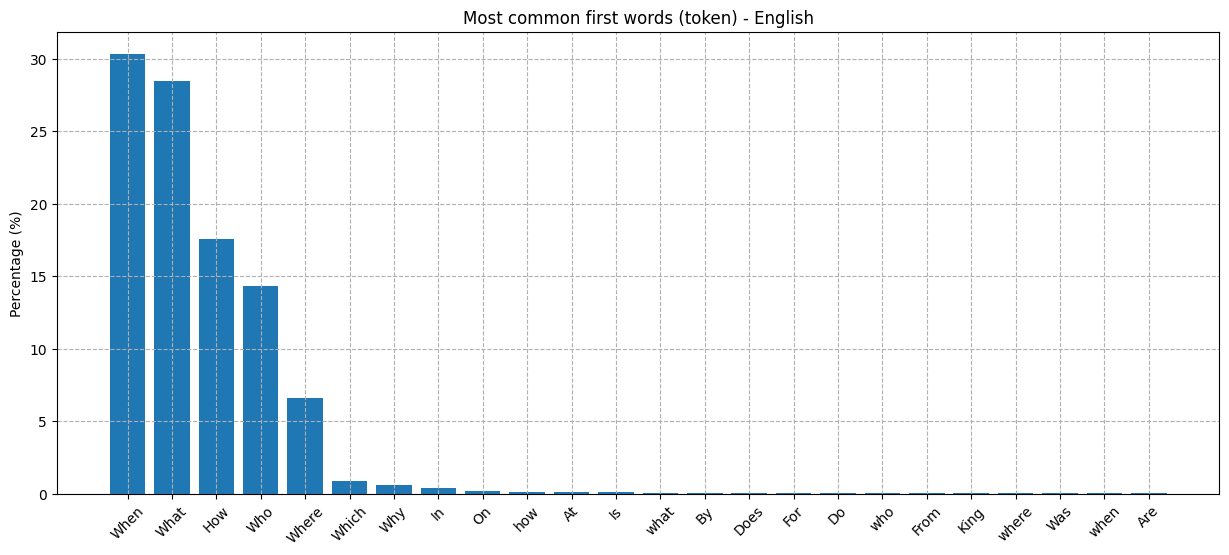

In [164]:
plot_most_common_words(firsts, "Most common first words (token) - English", top=25)

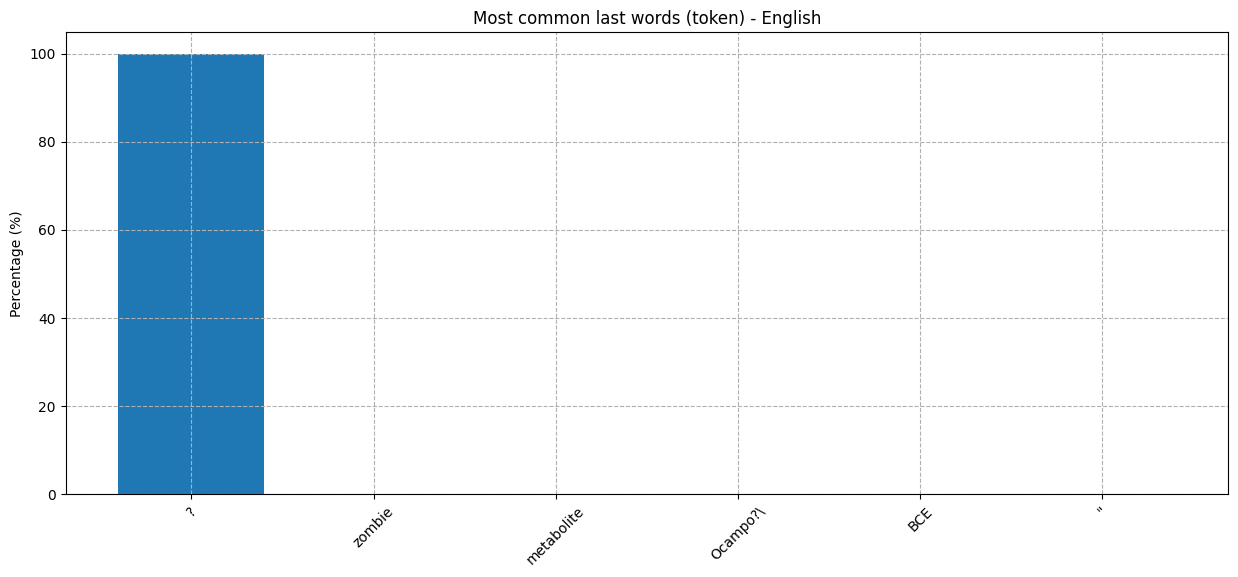

In [165]:
plot_most_common_words(lasts, "Most common last words (token) - English", top=25)

### Finnish trainset summary 

In [166]:
df_question = train_fi["question"]

firsts = get_firsts(df_question)
lasts = get_lasts(df_question)

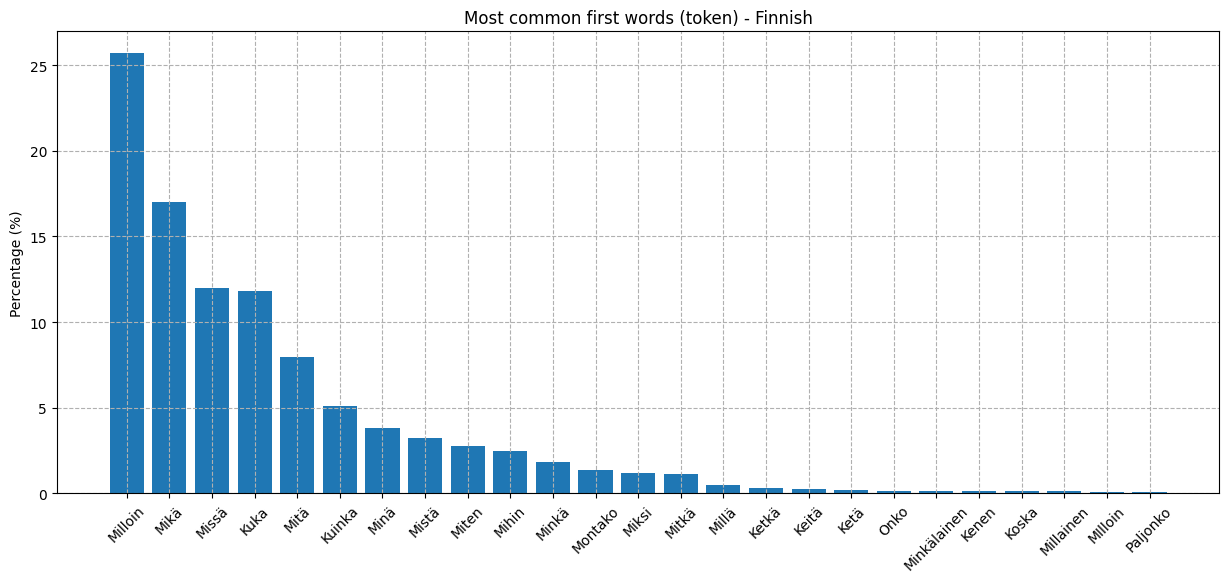

In [167]:
plot_most_common_words(firsts, "Most common first words (token) - Finnish", top=25)

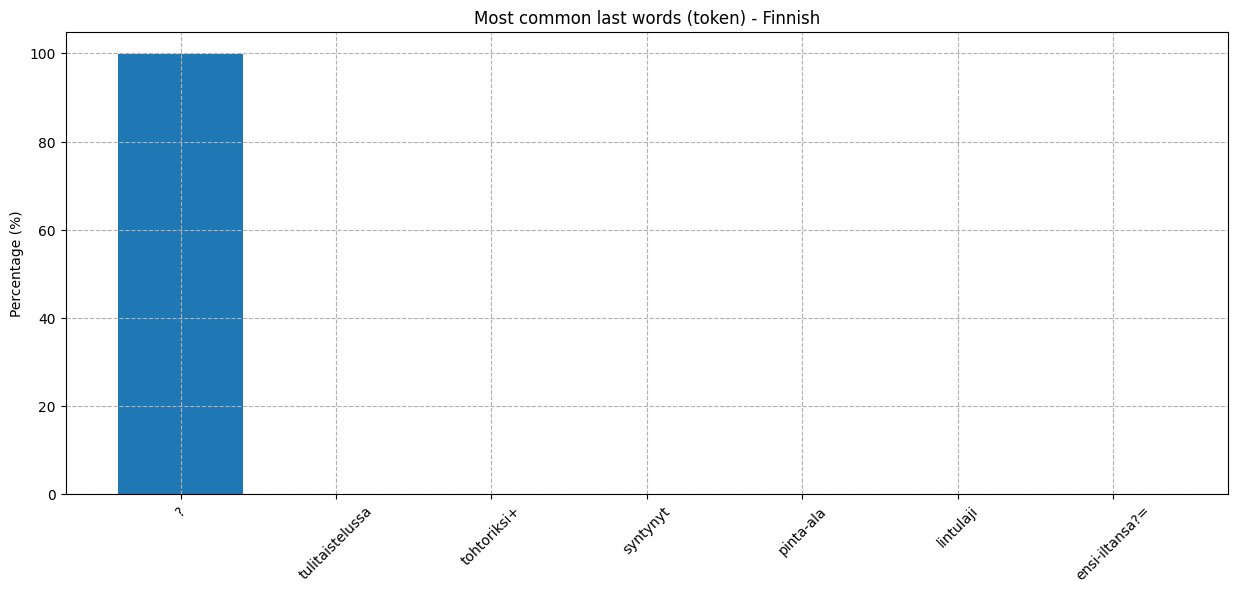

In [168]:
plot_most_common_words(lasts, "Most common last words (token) - Finnish", top=25)

### Japanese trainset summary 

Use a font which supports japanese characters.

In [169]:
import matplotlib.font_manager as fm
fprop = fm.FontProperties(fname='Osaka.ttc')

In [170]:
df_question = train_jp["question"]

firsts = get_firsts(df_question)
lasts = get_lasts(df_question)

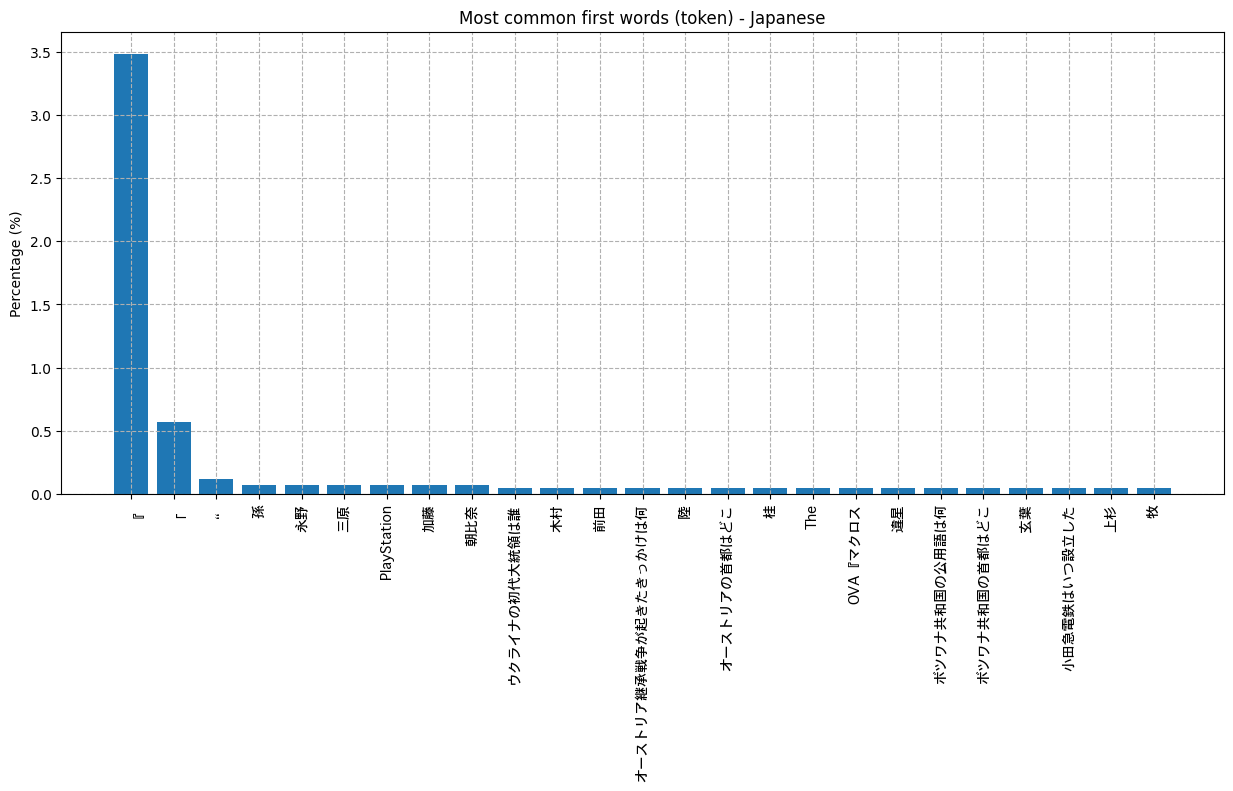

In [171]:
plot_most_common_words(firsts, "Most common first words (token) - Japanese", top=25, font_prop=fprop, rotation=90)

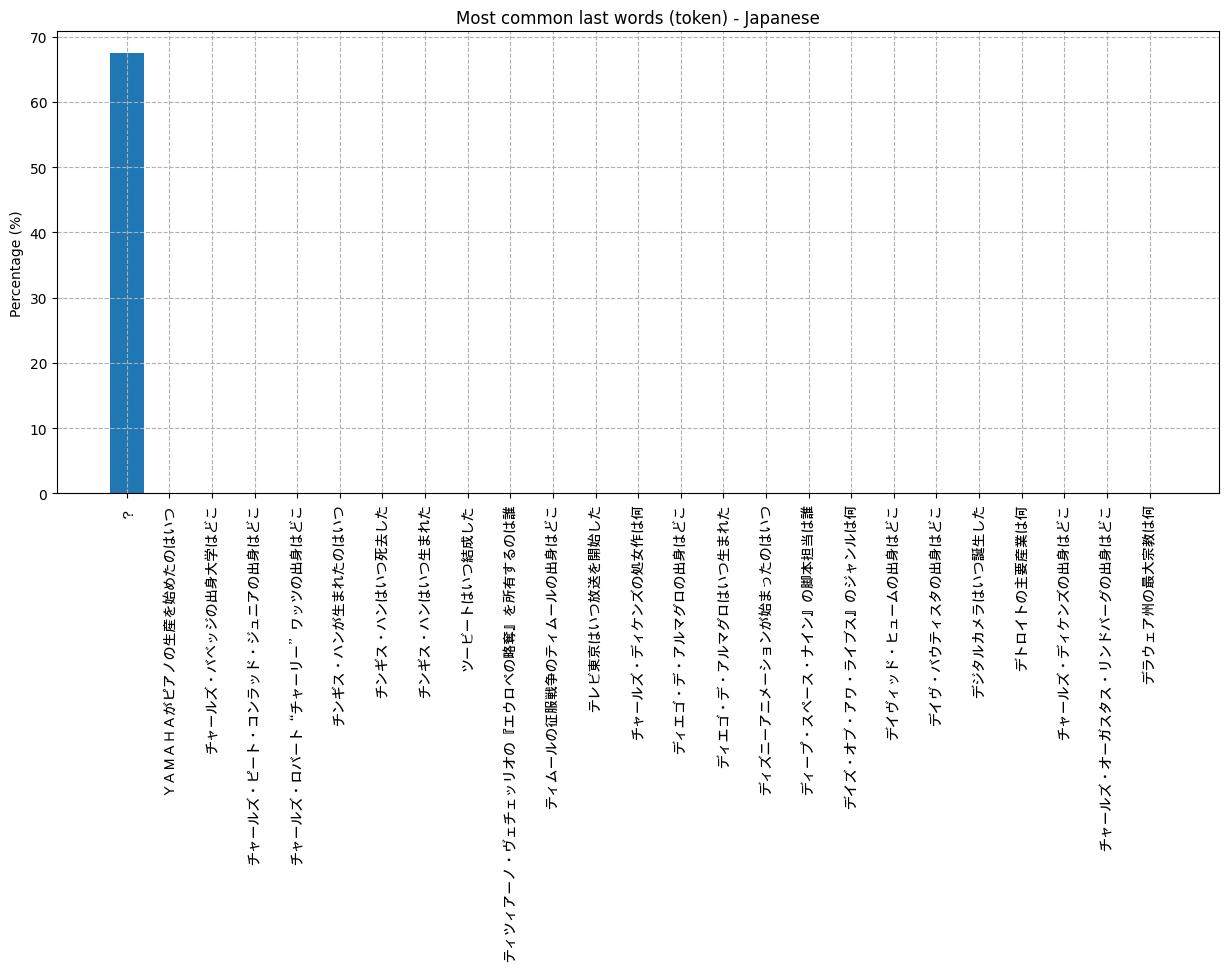

In [172]:
plot_most_common_words(lasts, "Most common last words (token) - Japanese", top=25, font_prop=fprop, rotation=90)

## Q1.2a

@TODO: Discuss why those features have been chosen.

In [174]:
def words_to_ids(word_lists):
    word_to_ix = {}
    for words in word_lists:
        for word in words:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
    return word_to_ix

In [175]:
def make_bow_vector(sentence, word_to_ix):
    vec = np.zeros(len(word_to_ix))
    for word in sentence:
        vec[word_to_ix[word]] += 1
    return vec

In [365]:
def get_lengths(data_feature):
    return np.array([len(words) for words in data_feature])

## Feature Exploration
### Distributions over the number of words
@TODO: move this into the previous exercise?

In [282]:
def plot_document_length_dist(dataset, title):
    lengths = get_lengths(dataset['document'])

    fig, ax = plt.subplots(figsize=(15,6))
    ax.grid(linestyle="--")
    ax.set_title(title)
    ax.set_ylabel("Percentage (%)")
    ax.set_xlabel("Number of tokens")

    ax.hist(lengths, bins=300, density=True) # let's use an histogram instead with fixed bins, since their is much variability.
    
    #ticks = np.linspace(min(uniques), max(uniques)+1, 10)
    #ax.set_xticks(ticks)

In [283]:
def plot_question_length_dist(dataset, title):
    question_lengths = get_lengths(dataset['question'])

    uniques, uniques_counts = np.unique(question_lengths, return_counts=True)
    index_sorted = np.argsort(uniques, axis=None)

    uniques_counts_percentage = uniques_counts / np.sum(uniques_counts) * 100

    fig, ax = plt.subplots(figsize=(15,6))
    ax.grid(linestyle="--")
    ax.set_title(title)
    ax.set_ylabel("Percentage (%)")
    ax.set_xlabel("Number of tokens")

    x = uniques[index_sorted]
    ax.bar(x, uniques_counts_percentage[index_sorted])
    ticks = np.arange(min(uniques), max(uniques)+1, 1)
    ax.set_xticks(ticks)

#### English

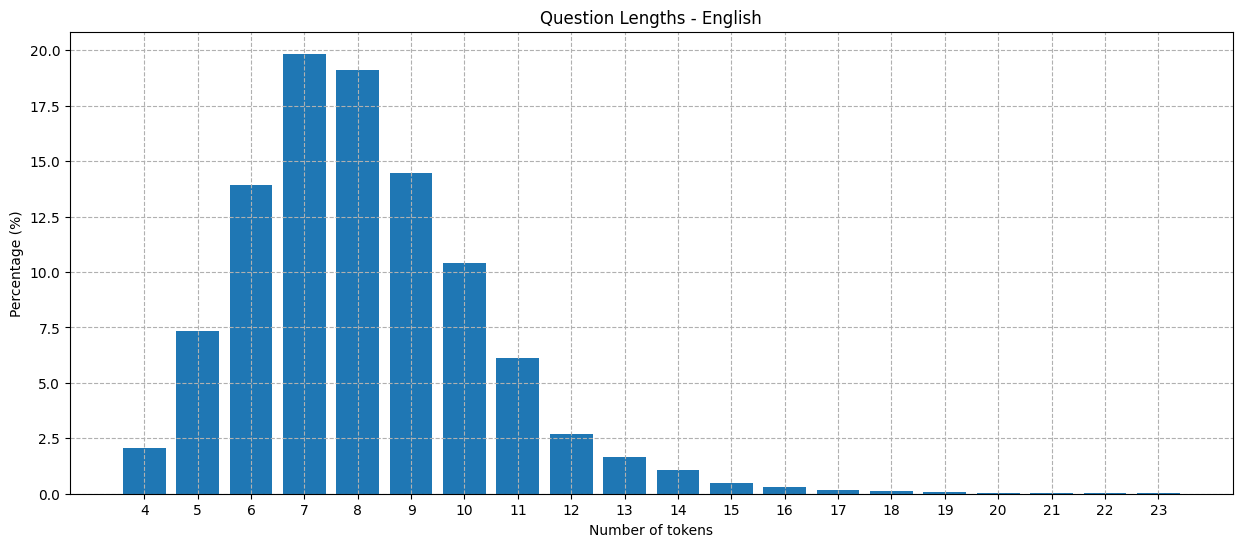

In [284]:
plot_question_length_dist(train_en, "Question Lengths - English")

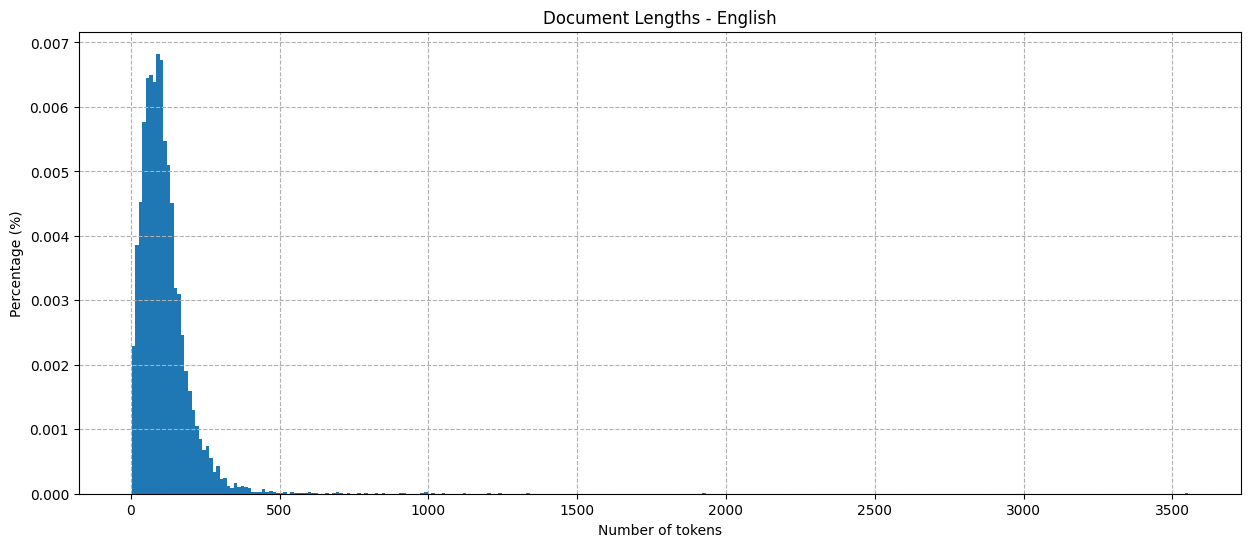

In [285]:
plot_document_length_dist(train_en, "Document Lengths - English")

#### Finnish

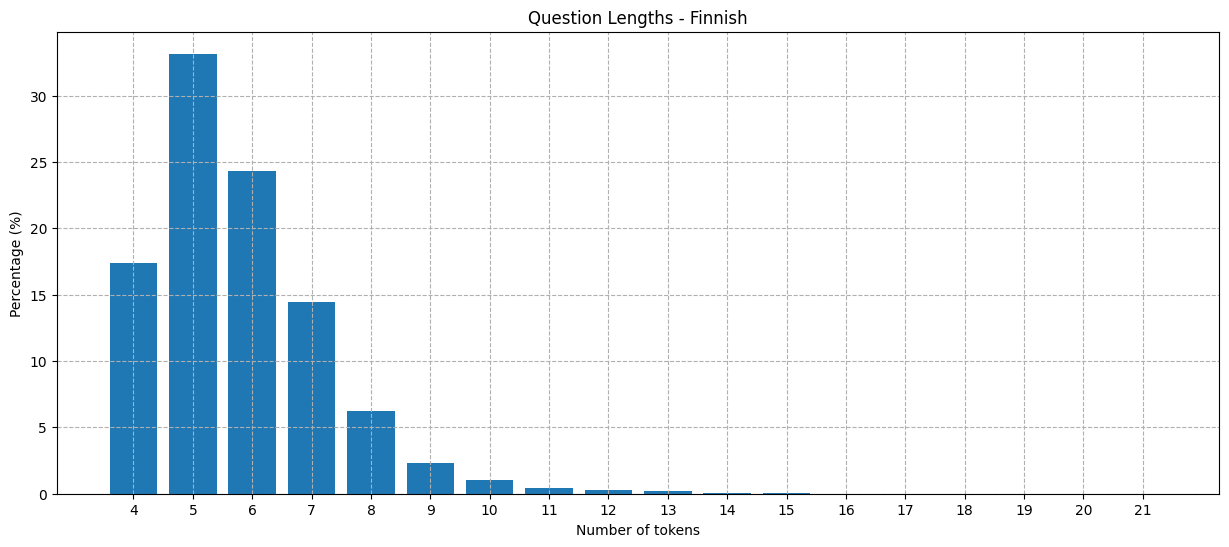

In [286]:
plot_question_length_dist(train_fi, "Question Lengths - Finnish")

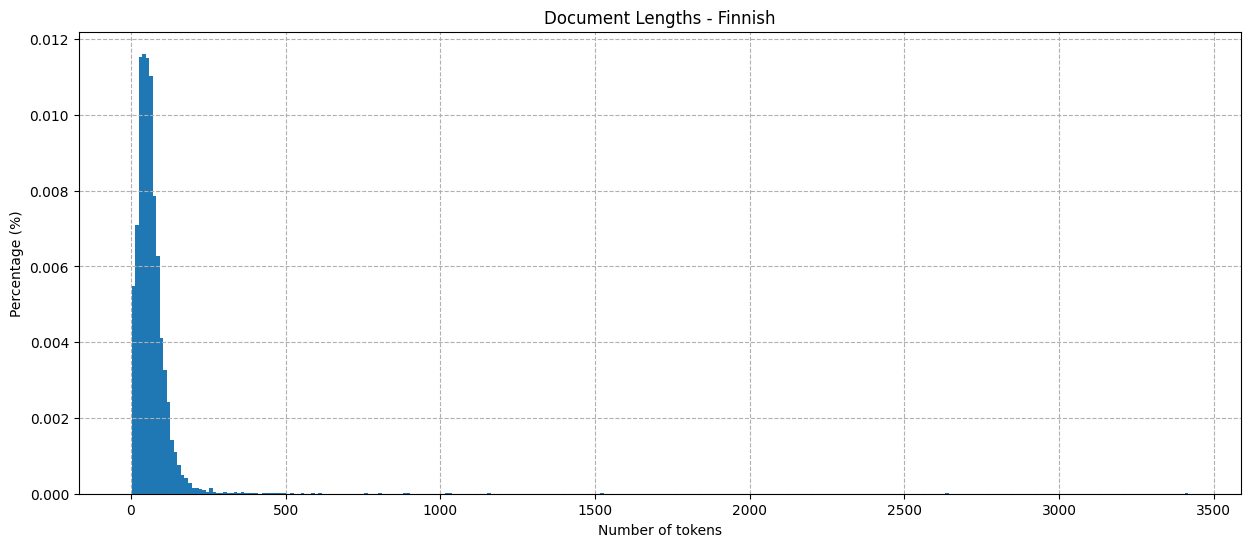

In [287]:
plot_document_length_dist(train_fi, "Document Lengths - Finnish")

#### Japenese

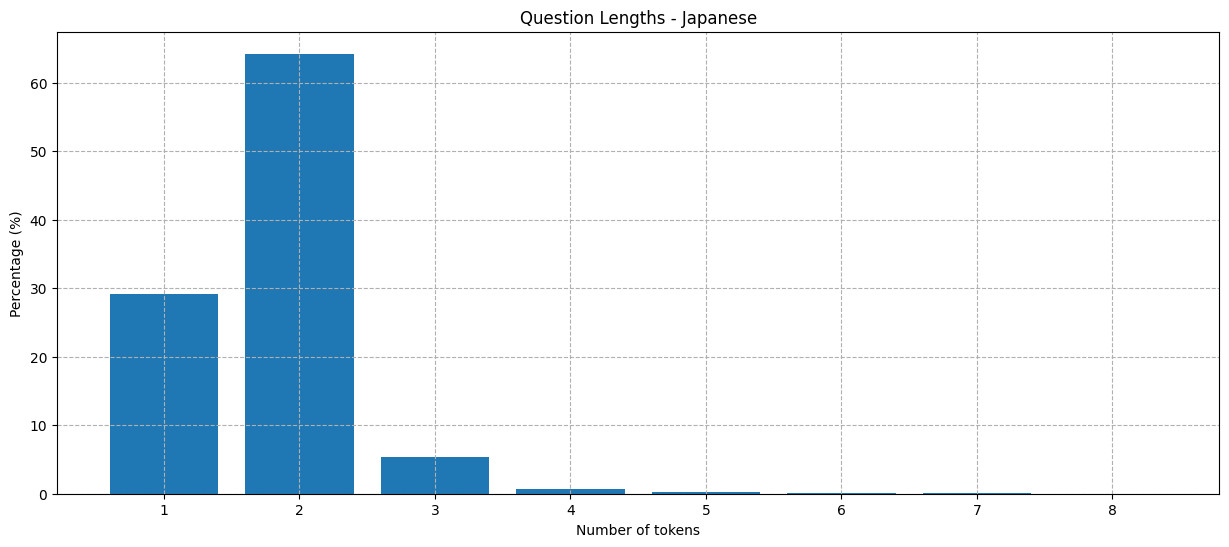

In [344]:
plot_question_length_dist(train_jp, "Question Lengths - Japanese")

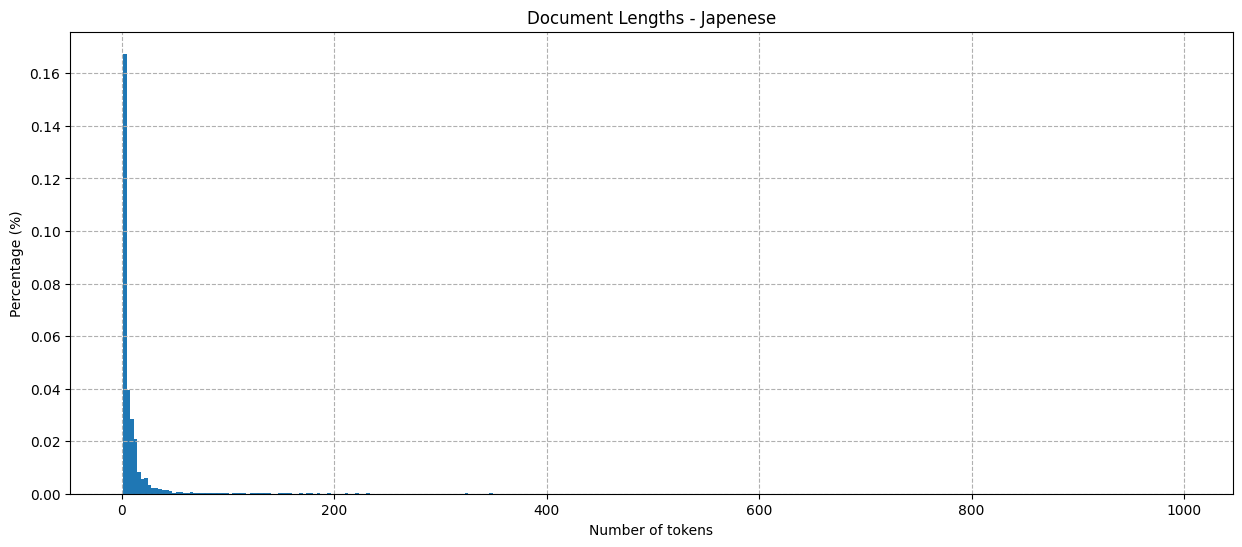

In [345]:
plot_document_length_dist(train_jp, "Document Lengths - Japenese")

### Features 

@ASK: should the model be simple, such that we can interprete the weights (+ features effect)?

#### Reason
OK:
- Bag of Words for Question tokens (some words are easier to answer, e.g. When vs How)
- Number of tokens in document (A longer document is more likely to have the correct answer than a short document)
- Number of tokens in question (A longer answer looks for a very specific answer)
-----------------
Ignored:
- Bag of Words for Document tokens (probably doesn't make sense)



In [290]:
word_ids = words_to_ids(pd.concat([train_en['question'], validation_en['question']]))
print("{} unique words".format(len(word_ids)))

5511 unique words


In [291]:
def get_bag_of_words(data_feature, word_ids):
    X = np.empty((len(data_feature), len(word_ids)))
    for i, _ in enumerate(data_feature):
        X[i] = make_bow_vector(data_feature.iloc[i], word_ids)
    return X

--------------------
#### Too Slow

In [379]:
# @Note: Too slow. This corresponds to the overlap between the two features and taking into account which words overlap
# A simpler version is to give a single numeric value for the fractions of words overlapping.
def get_bag_of_words_overlaps(data_feature_1, data_feature_2, word_ids):
    bow_1 = get_bag_of_words(data_feature_1, word_ids)
    bow_2 = get_bag_of_words(data_feature_2, word_ids)
    return bow_1 * bow_2

In [380]:
word_ids_all = words_to_ids(pd.concat([train_en['question'], train_en['document'], validation_en['question'], validation_en['document']]))
print("{} unique words".format(len(word_ids_all)))

get_bag_of_words_overlaps(train_en['question'], train_en['document'], word_ids_all)

66811 unique words


MemoryError: Unable to allocate 3.68 GiB for an array with shape (7389, 66811) and data type float64

-----------------------


In [378]:
word_ids_all = words_to_ids(pd.concat([train_en['question'], train_en['document'], validation_en['question'], validation_en['document']]))
print("{} unique words".format(len(word_ids_all)))

a = get_bag_of_words(train_en['document'], word_ids)
print(a.shape)

66811 unique words
(7389, 66811)


In [367]:
# @TODO: incomplete
def count_word_overlaps(data_feature, reference_data_feature, words_ids):
    assert(data_feature.shape[0] == reference_data_feature.shape[0])
    
    X = np.empty_like(data_feature)
    for i, _ in enumerate(data_feature):
        bow_reference = make_bow_vector(reference_data_feature.iloc[i], word_ids)
        
        #X[i] = 0
    return X

In [364]:
count_word_overlaps(train_en['question'], train_en['document'])

array([array([1., 1., 1., ..., 0., 0., 0.]),
       array([0., 1., 0., ..., 0., 0., 0.]),
       array([1., 0., 0., ..., 0., 0., 0.]), ...,
       array([0., 1., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.])], dtype=object)

In [312]:
def get_X(dataset):
    bow = get_bag_of_words(dataset['question'], word_ids)
    document_lengths = get_lengths(dataset['document']).reshape((-1,1))
    question_lengths = get_lengths(dataset['question']).reshape((-1,1))
    X = np.concatenate((bow, document_lengths, question_lengths), axis=1)
    return X

In [366]:
# If the question is answered, then predict "1". Otherwise predict "0".
def get_target(data):
    answer_set = data['document_answer_region']
    y = np.empty(answer_set.shape[0])

    for i, answer in enumerate(answer_set):
        if type(answer) == Annotation_error and answer == Annotation_error.UNANSWERED: # @TODO: if we don't do the annotation stuff, then we can check for -1 here
            y[i] = 0
        else:
            y[i] = 1
    return y

In [313]:
X_train = get_X(train_en)
y_train = get_target(train_en)

In [314]:
num_answered = np.sum(y_train == 1)
num_unanswered = np.sum(y_train == 0)

print("Questions answered: {}, unanswered: {}.".format(num_answered, num_unanswered))

Questions answered: 3696, unanswered: 3693.


In [315]:
X_validation = get_X(validation_en)
y_validation = get_target(validation_en)

## Q1.2b

In [316]:
classifier = LogisticRegression(penalty='l2', max_iter=1000)

# @TODO:
# classifier_random = RandomizedSearchCV(
#     estimator=classifier,
#     param_distributions=hp,
#     n_iter=100,
#     cv=5,
#     verbose=2,
#     random_state=1000,
#     n_jobs=-1,
#     scoring='f1'
# )

# classifier_random.fit(X_train, y_train)
# print(classifier_random.best_params_)
# print(classifier_random.best_score_)
# model = classifier_random.best_estimator_

classifier.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [336]:
intercept = classifier.intercept_
coef = classifier.coef_[0]

In [337]:
coef[-1]

-0.0034365396766347827

In [339]:
coef[word_ids["When"]]

0.01607578160131135

## Q1.2c

Let's do prediction on the validation set for each language and compute the accuracy.

In [319]:
preds = classifier.predict(X_validation)
print(classification_report(y_validation, preds))

              precision    recall  f1-score   support

         0.0       0.56      0.59      0.57       495
         1.0       0.56      0.54      0.55       495

    accuracy                           0.56       990
   macro avg       0.56      0.56      0.56       990
weighted avg       0.56      0.56      0.56       990



In [320]:
accuracy = np.sum(y_validation == preds) / y_validation.shape[0]
accuracy

0.5616161616161616


@TODO: other languages

## TODOs
- also BOW for document feature?
- (Proposed in project description) Answer overlap between document and text!!! I thought the document would be empty if there was no answer I guess not!!!
- N-grams (proposed in project description)
- Look at weights (what impact do the features have: How, When words + answer length)
- Ignore CASE for bag of words?
- Discuss discuss degrees of freedom (weights vs training data)
- BOW vectors multiplied (Words overlap)

---------------

- Plot where the user selects the threshold/cutoff?
- Multiple models (logistic regression, ANN) + features (2d matrix with accuracy)
- Discuss in paper how we use annotations as an indication on how well the tokenizer works (also the end of sentence, which should end with "?" without any prefix. And question length should probably be roughly the same for each language?
- Reconsider tokenization of japanese

In [143]:
train_en

,language,question,document_title,document,document_answer_region
0,english,"[When, was, quantum, field, theory, developed, ?]","[Quantum, field, theory]","[Quantum, field, theory, naturally, began, wit...","(25, 26)"
1,english,"[Who, was, the, first, Nobel, prize, winner, f...","[List, of, Nobel, laureates, in, Literature]","[The, Nobel, Prize, in, Literature, (, Swedish...","(111, 113)"
2,english,"[When, is, the, dialectical, method, used, ?]",[Dialectic],"[Dialectic, or, dialectics, (, Greek, :, διαλε...","(26, 49)"
3,english,"[Who, invented, Hangul, ?]","[Origin, of, Hangul]","[Hangul, was, personally, created, and, promul...","(15, 18)"
4,english,"[What, do, Grasshoppers, eat, ?]",[Grasshopper],"[Grasshoppers, are, plant, -, eaters, ,, with,...","(0, 37)"
...,...,...,...,...,...
7384,english,"[What, was, Neil, Brooks, ', fastest, recorded...","[Swimming, at, the, 1980, Summer, Olympics, –,...","[The, medley, relay, was, scheduled, in, the, ...",Annotation_error.UNANSWERED
7385,english,"[Who, are, the, three, most, important, easter...","[Eastern, philosophy]","[Sāmkhya, is, a, dualist, philosophical, tradi...",Annotation_error.UNANSWERED
7386,english,"[Who, was, costume, designer, for, the, first,...","[John, Mollo]","[Mollo, was, surprised, by, the, success, of, ...",Annotation_error.UNANSWERED
7387,english,"[Who, developed, the, first, thermonuclear, we...","[History, of, nuclear, weapons]","[In, the, end, ,, President, Truman, made, the...",Annotation_error.UNANSWERED
